In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections
import seaborn as sns
from scipy.spatial import distance
import powerlaw
import heapq
import os
import gc
import pickle
import math
import random
from sklearn.linear_model import LinearRegression

from base_network_extensions import *

In [101]:
def generate_weighted_p(G):
    '''Generate weighted p to select nodes for PA model'''
    total_degree = 0
    for i in range(G.node_count):
        total_degree += G.degree[i]
    p = []
    for i in range(G.node_count):
        p.append(G.degree[i] / total_degree)
    return p

def pbc_distances(G, node=False):
    '''
    Calculated the periodic boundary condition distances given coordinates and dimensions of space
    Coordinates need to be passed in an (n, d) numpy array 
    params:
        G: the graph
        node: node label to calculate distances from, if none use last node
    return:
        distances - distances given in a n x n numpy array, where distances[i][j] is the pbc
            distance between points i and j
    '''
    coordinates = []
    dimensions = G.size
    for i in range(G.node_count):
        coordinates.append(G.node[i]['coordinate'])    
    coordinates = np.array(coordinates)
    
    num_dim = coordinates.shape[1]
    num_coords = coordinates.shape[0]
    delta_blocks = []
    
    for d in range(num_dim):
        dimension = dimensions[d]
        coordinate_block = coordinates.T[d]
        if(node is False):
            node = G.node_count - 1
        delta = np.abs(coordinate_block - G.node[node]['coordinate'][d])
        delta = np.where(delta > 0.5 * dimension, dimension - delta, delta)
        
        delta_blocks.append(delta ** 2)
    
    distances = np.sqrt(np.sum(delta_blocks, axis=0))
    return distances

def generate_weighted_distance_p(G, node=False, beta=0.0):
    '''Generate weighted p to select nodes for spatial PA model
    pass in a node label to determine node distance
    beta is distance modifier
    '''
    if(node is False):
        node = G.node_count - 1
    distances = pbc_distances(G, node=node)
    distances = distances ** beta
    distances[node] = 0
    degrees = np.array(G.degree).T[1]
    weighted_degree = degrees * distances
    
    total_weighted_degree = np.sum(weighted_degree)
    weighted_probability = weighted_degree / total_weighted_degree
    
    return weighted_probability
    
    

In [112]:
g.node_count

510

In [114]:
print(generate_weighted_distance_p(g, beta=-3.0))
print(generate_weighted_p(g))

[  7.87988688e-04   6.06827960e-04   1.85207034e-03   4.62843042e-04
   5.16001763e-04   5.50613770e-04   8.09268357e-04   3.33948415e-03
   1.21125739e-03   9.58609767e-04   5.98556687e-04   2.49785472e-04
   1.94281577e-03   2.07075318e-04   2.12845108e-04   4.95966310e-05
   1.41460547e-04   9.06749410e-03   2.01676210e-04   4.58650471e-04
   2.80507739e-04   2.85352068e-04   8.82631321e-05   2.01424852e-03
   3.45082607e-04   2.19842788e-04   6.48334970e-04   7.11574823e-03
   2.73101681e-04   2.64033830e-03   3.21127048e-04   7.24872523e-04
   1.63695299e-03   9.18983677e-05   1.32146727e-03   1.81020122e-04
   1.17364837e-03   3.17138345e-04   7.35025344e-05   2.36972067e-04
   2.13604435e-04   1.64725763e-03   1.51590475e-03   1.17802582e-01
   1.27890274e-04   3.89237797e-04   1.50426868e-04   1.52319394e-03
   5.00194820e-03   1.00797794e-04   4.92883799e-04   2.18289117e-04
   1.93631253e-04   1.26900289e-04   2.27654833e-03   2.23532439e-04
   3.28208129e-04   1.02767158e-02

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in power


In [22]:
node = 5
for d in range(num_dim):
    dimension = dimensions[d]
    coordinate_block = coordinates.T[d]

    delta = np.abs(coordinate_block - g.node[node]['coordinate'][d])
    delta = np.where(delta > 0.5 * dimension, dimension - delta, delta)

    delta_blocks.append(delta ** 2)

distances = np.sqrt(np.sum(delta_blocks, axis=0))

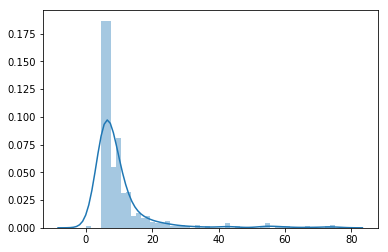

In [95]:
'''
BA Preferential Attachment Model
'''

g = SimpleSpatialGraph(size=[100, 100])
m0 = 10 #starting number of nodes
m = 5 #number of edges a new node adds
n = 500 #number of nodes to add i.e. timesteps to undergo
g.total_degree = (m0 * (m0 - 1)) / 2
g.node_labels = []
#create initial nodes
for i in range(m0):
    g.add_node()
    
    
#connect initial nodes
for i in range(g.node_count):
    for j in range(i+1, g.node_count):
        g.add_edge(i, j)

        
for i in range(n):
    
    g.add_node()
    new_node = g.node_count
    
    edges_added = 0
    while(edges_added < m):
        deg_num = np.random.randint(0, g.total_degree)
        node_edge = np.random.choice(np.arange(0, g.node_count), p=generate_weighted_p(g))
        
        if(not g.has_edge(new_node, node_edge)):
            g.add_edge(new_node, node_edge)
            edges_added += 1
    
degrees = graph_degree_distribution(g)

In [118]:
'''
BA Preferential Attachment Model
'''
def graph_model(m0=10, m=5, n=500, beta=0.0):
    '''
    Create spatial preferential attachment model
    '''
    g = SimpleSpatialGraph(size=[100, 100])
    #m0 starting number of nodes
    #m number of edges a new node adds
    #n number of nodes to add i.e. timesteps to undergo
    #beta -0.5

    g.total_degree = (m0 * (m0 - 1)) / 2
    g.node_labels = []
    #create initial nodes
    for i in range(m0):
        g.add_node()


    #connect initial nodes
    for i in range(g.node_count):
        for j in range(i+1, g.node_count):
            g.add_edge(i, j)


    for i in range(n):
        new_node = g.node_count
        g.add_node()

        edges_added = 0
        while(edges_added < m):
            deg_num = np.random.randint(0, g.total_degree)
            node_edge = np.random.choice(np.arange(0, g.node_count), p=generate_weighted_distance_p(g, beta=beta))

            if(not g.has_edge(new_node, node_edge)):
                g.add_edge(new_node, node_edge)
                edges_added += 1

    return g


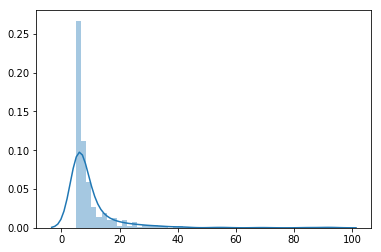

In [97]:
g2 = nx.barabasi_albert_graph(511, 5)
degrees = graph_degree_distribution(g2)

In [ ]:
'''
Run simulation for normal_difference_distance_heavistep graph across range of thresholds and betas
'''
betas = [0.0, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0]

num_plots = 7

plt.figure(figsize=(16, 8))

for i in range(num_plots):
    beta = betas[i]
    g = graph_model(beta=beta)    

    degrees = graph_degree_distribution_subplot(g, 3, 3, i+1)

In [103]:
g = graph_model()

c:\users\andy\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in power


In [107]:
def graph_spatial_network_plot_valued(G, values=False, graph_edges=False, highlight_edges=False, color_points=False):
  '''
  Create a plot showing what a 2D spatial graph looks like, coloring by passed values and sized by degree
  params:
    G: passed in SimpleSpatialGraph
    values: values according to the labels of the nodes
    graph_edges: graph edges as well (this function takes into account periodic boundary conditions)
    highlight_edges: Optionally parameter to draw in specific edges highlighted, will 
        also highlight the latest node
    color_points: array of color labels if coloring points specifically
  '''
  X = []
  Y = []
  degrees = []
  scatter_values = []
  
  plt.figure(figsize=(16, 16))
  for i in list(G.nodes):
    coordinate = G.nodes[i]['coordinate']
    X.append(coordinate[0])
    Y.append(coordinate[1])
    degrees.append(G.degree[i])
    if(values):
      scatter_values.append(values[i])
  
  if(graph_edges):
    for i in G.edges:
      coordinate_i = G.nodes[i[0]]['coordinate']
      coordinate_j = G.nodes[i[1]]['coordinate']
      points = False
      if(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2 and
          abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
        max_x = max(coordinate_i[0], coordinate_j[0])
        max_y = max(coordinate_i[1], coordinate_j[1])
        min_x = min(coordinate_i[0], coordinate_j[0])
        min_y = min(coordinate_i[1], coordinate_j[1])
        x1 = (max_x, max_x + 50)
        x2 = (min_x, min_x - 50)
        y1 = (max_y, max_y + 50)
        y2 = (min_y, min_y - 50)
        points = (x1, x2, y1, y2)
      elif(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2):
        coordinates = sorted([[coordinate_i[0], coordinate_i[1]], 
          [coordinate_j[0], coordinate_j[1]]])
        x1 = (coordinates[1][0], coordinates[1][0] + 50)
        x2 = (coordinates[0][0], coordinates[0][0] - 50)
        y1 = (coordinates[1][1], coordinates[0][1])
        y2 = (coordinates[0][1], coordinates[1][1])
        points = (x1, x2, y1, y2)
      elif(abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
        coordinates = sorted([[coordinate_i[1], coordinate_i[0]], 
          [coordinate_j[1], coordinate_j[0]]])
        y1 = (coordinates[1][0], coordinates[1][0] + 50)
        y2 = (coordinates[0][0], coordinates[0][0] - 50)
        x1 = (coordinates[1][1], coordinates[0][1])
        x2 = (coordinates[0][1], coordinates[1][1])
        points = (x1, x2, y1, y2)

      if(points):
        plt.plot(points[0], points[2], alpha=0.2, color='grey')
        plt.plot(points[1], points[3], alpha=0.2, color='grey')
      else:
        x = (coordinate_i[0], coordinate_j[0])
        y = (coordinate_i[1], coordinate_j[1])
        plt.plot(x, y, alpha=0.2, color='grey')

  if(highlight_edges):
    for i in highlight_edges:
      coordinate_i = G.nodes[i[0]]['coordinate']
      coordinate_j = G.nodes[i[1]]['coordinate']
      x = (coordinate_i[0], coordinate_j[0])
      y = (coordinate_i[1], coordinate_j[1])
      plt.plot(x, y, alpha=0.2, color='red')

  if(color_points):
    plt.scatter(X, Y, c=color_points, s=degrees)
  if(values):
    plt.scatter(X, Y, c=scatter_values, s=degrees, cmap='viridis')
    plt.colorbar()    
  else:
    plt.scatter(X, Y, s=degrees)

  if(highlight_edges):
    node = G.nodes[len(G.nodes) - 1]
    x = [node['coordinate'][0]]
    y = [node['coordinate'][1]]
    plt.scatter(x, y, c='red')

  plt.xlim([0, G.size[0]])
  plt.ylim([0, G.size[1]])
    

def plot_centrality_correlation(G, centrality1=False, centrality2=False):
    '''
    Plot the correlations between centralities - will plot a grid of correlations,
    each plot will be ordered by the value on the x-axis
    Returns the calculated centralities dictionary
    '''
    centralities = {
        'Degree': G.degree
    }
    sorting_dict = {}
    print('Calculating betweenness')
    centralities['Betweenness'] = nx.betweenness_centrality(g)
    print('Calculating closeness')
    centralities['Closeness'] = nx.closeness_centrality(g)
    print('Gathering fitnesses')
    fitnesses = {}
    for i in range(G.node_count):
        fitnesses[i] = G.node[i]['fitness']
    centralities['Fitness'] = fitnesses
    
    print('Plotting graphs')
    plt.figure(figsize=(16, 16))
    #plt.tight_layout()
    
    for i in range(G.node_count):
        sorting_dict[i] = {}
        for key in centralities:
            sorting_dict[i][key] = centralities[key][i]
    
    for i, key1 in enumerate(centralities):
        #key1 will be the y-axis
        for j, key2 in enumerate(centralities):
            plt.subplot(len(centralities), len(centralities), i * len(centralities) + j + 1)
            #plot histogram along diagonal
            if(i == j):
                hist_values = []
                for k in range(G.node_count):
                    hist_values.append(centralities[key1][k])
                sns.distplot(hist_values)
                plt.xlabel(key1)
                plt.ylabel('Proportion')
            else:
                sorted_keys = sorted(sorting_dict, key=lambda x: (sorting_dict[x][key2], sorting_dict[x][key1]))
                x = []
                y = []
                for k in range(G.node_count):
                    x.append(centralities[key2][sorted_keys[k]])
                    y.append(centralities[key1][sorted_keys[k]])
                plt.scatter(x, y, alpha=0.4)
                plt.xlabel(key2)
                plt.ylabel(key1)
    
    plt.tight_layout()
    return centralities

In [ ]:
graph_spatial_network_plot_valued(graph_model(beta=-0.5), graph_edges=True)

In [ ]:
graph_spatial_network_plot_valued(graph_model(beta=-3.0), graph_edges=True)